In [40]:
from math import sin, cos, remainder
import numpy as np
    
class Vehicle:
    def __init__(self, x=np.array([0,0,0,0]), u=np.array([0,0]), T=0.01, measurement_stds=np.array([0.1,0.1,0.0001,0.0002])):
        # x: x, y, theta, v
        # u: a, omega
        self.T = T
        self.measurement_stds = measurement_stds

        self.x = x
        self.u = u
        self.x_data = np.empty((0,4), float)
        self.u_data = np.empty((0,2), float)

    def f(self, x, u, enable_noise=True):
        #Zero-order hold discretization. x_dot ≈ 1/dt(x_k+1 - x_k)
        #Ad = I + A*dt, Bd = B*dt
        #x_dot = v*cos(theta)
        #y_dot = v*sin(theta)
        #theta_dot = omega
        #v_dot = a

        B = np.array([
            [0, 0],
            [0, 0],
            [0, 1],
            [1, 0]
        ])

        A = np.zeros((self.x.size, self.x.size))
        A[0,3] = cos(x[2])
        A[1,3] = sin(x[2])
        
        Ad = np.eye(self.x.size) + A*self.T
        Bd = B*self.T

        x_new = Ad @ x + Bd @ (u + enable_noise*np.random.normal(0, self.measurement_stds[-2:]))
        x_new[2] = remainder(x_new[2], 2*np.pi)  # Limit to -pi~pi
        return x_new

    def F(self, x):
        return np.array([
            [1, 0, -x[3]*self.T*sin(x[2]), self.T*cos(x[2])],
            [0, 1, x[3]*self.T*cos(x[2]), self.T*sin(x[2])],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def g(self, x, enable_noise=True):
        Cd = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        return Cd @ x + enable_noise*np.random.normal(0, self.measurement_stds[:2]).T

    def G(self):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

Three different nosie levels for position, angular rate and linear acceleration measurements are compared. Initialize one of the corresponding measurements noise standard deviations below. 

In addition, a longer simulation time is performed for the last cell.

In [41]:
# Low noise in position, angular rate and linear acceleration
# Short simulation

measurement_stds = np.array([0.1,0.1,0.001,0.002])
num_iterations = 7000

In [42]:
# Low position noise, high angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array([0.1,0.1,0.01,0.02])
num_iterations = 7000

In [43]:
# High position noise, low angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array(([1.0,1.0,0.001,0.002]))
num_iterations = 7000

In [44]:
# Low noise in position, angular rate and linear acceleration
# Long simulation

measurement_stds = np.array(([0.1,0.1,0.001,0.002]))
num_iterations = 40000

In [45]:
from cgitb import enable
from time import time
from math import remainder
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   #For repeatability

num_states = 4
num_measurements = 2
num_iekf_iterations = 10

position_update_freq = 100
timesteps = np.arange(0,num_iterations)

trajectory = np.empty((0,num_states), float)
ground_truth = np.empty((0,num_states), float)
NIS = np.empty((0,1), float)
NEES = np.empty((0,1), float)

#Initialize model
x0 = np.array([0,0,0,0])
P0 = 1e-4*np.eye(num_states)
gt = x0

vehicle = Vehicle(x=x0, measurement_stds=measurement_stds)

u = np.vstack((num_iterations*[0.5], num_iterations*[0.5]))
u[0, num_iterations//4:3*num_iterations//4] = 0 # Drive in a circle for 3/5 the simulation

x_prev = x0
P_prev = P0

Q = np.diag([2e-2,2e-2,1e-4,2e-4])**2
R = np.diag([1.5e-1,1.5e-1])**2

G = vehicle.G()

k = 0
while k <= num_iterations - 1:
    
    #Prediction step
    P_pred = vehicle.F(x_prev) @ P_prev @ vehicle.F(x_prev).T + Q
    x_pred = vehicle.f(x_prev, u[:,k])
    
    #Kalman gain and covariance
    S = G @ P_pred @ G.T + R    # Innovation covariance
    K = np.linalg.solve(S.T, (P_pred @ G.T).T).T   #Faster than P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + R)
    P = (np.eye(num_states) - K @ G) @ P_pred
    P_prev = P
    
    if (k % position_update_freq == 0):
        #Update step
        x_op = x_pred
        y = vehicle.g(x_prev, enable_noise=True)
        g = vehicle.g(x_pred, enable_noise=False)
        for _ in range(num_iekf_iterations):
            y_op = vehicle.g(x_op, enable_noise=False)
            x = x_pred + K @ (y - y_op - G @ (x_pred - x_op))
            x_prev = x
            x_op = x
        innovation = y - g

        NIS = np.vstack((NIS, innovation.T @ np.linalg.solve(S, innovation)))
    else:
        x = x_pred
        x_prev = x

    #Store estimated trajectory
    trajectory = np.vstack((trajectory, x))

    #Store ground truth
    gt = vehicle.f(gt, u[:,k], enable_noise=False)
    ground_truth = np.vstack((ground_truth, gt))
    estimation_error = gt - x
    estimation_error[2] = remainder(estimation_error[2], 2*np.pi) # Limit to 0~2pi

    NEES = np.vstack((NEES, estimation_error.T @ np.linalg.solve(P, estimation_error)))

    #Count iterations
    k+=1
ANIS = np.mean(NIS)
ANEES = np.mean(NEES)

ANIS: 12.096663439978126
ANEES: 130.27732246293914


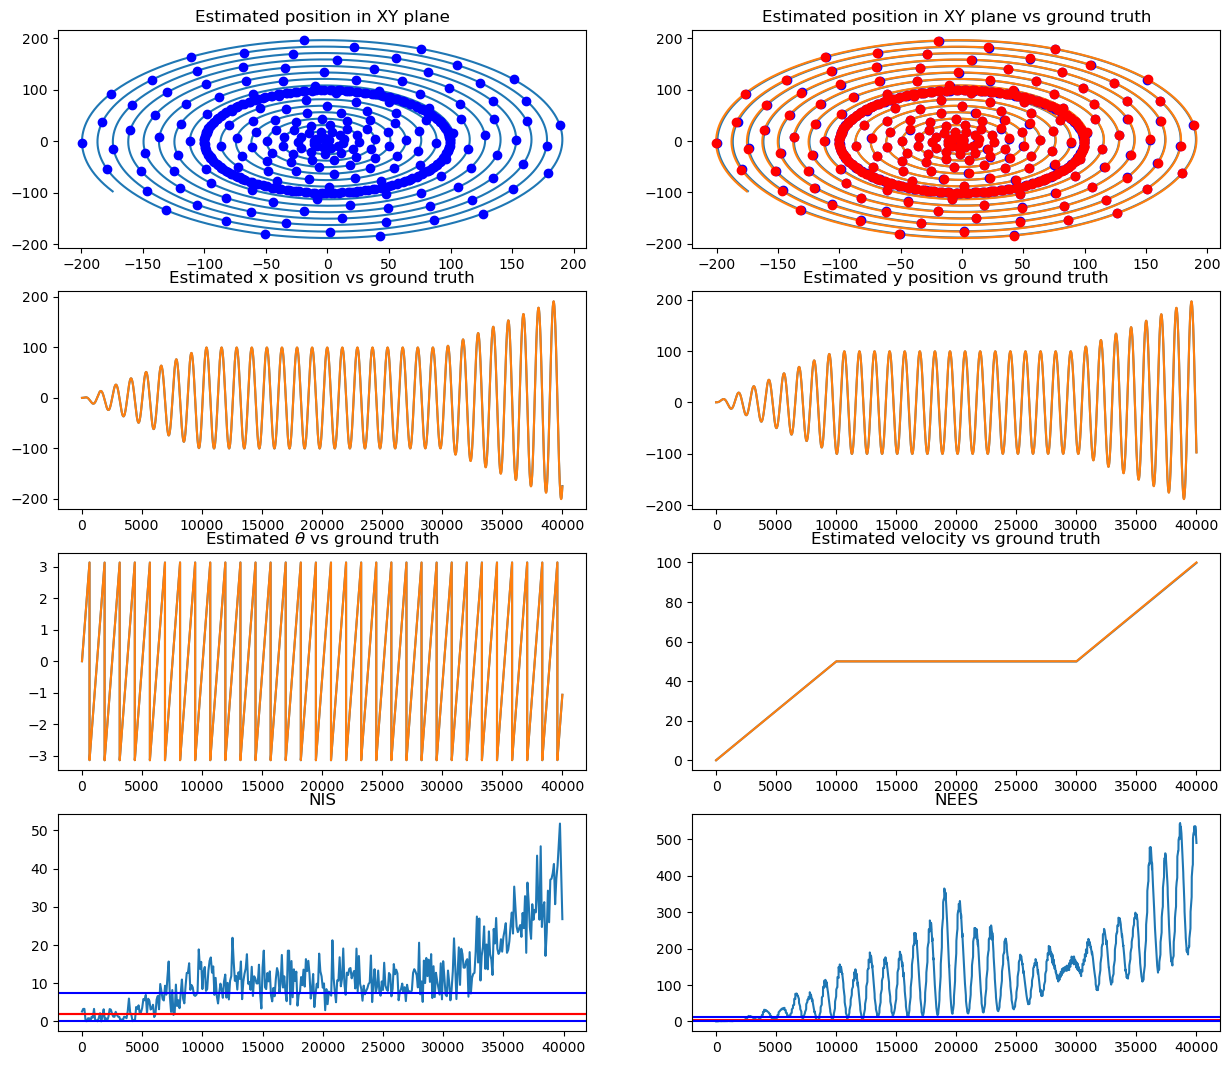

In [46]:
from scipy.stats.distributions import chi2

print(f"ANIS: {ANIS}\nANEES: {ANEES}")

confidence = 0.95
alpha = 1 - confidence
NEES_bounds = [chi2.ppf(alpha/2, df=num_states), chi2.ppf(1-alpha/2, df=num_states)]
NIS_bounds = [chi2.ppf(alpha/2, df=num_measurements), chi2.ppf(1-alpha/2, df=num_measurements)]

#Plotting
plt.rcParams['figure.figsize'] = [15, 13]
fig, axs = plt.subplots(4, 2)
axs[0,0].plot(trajectory[:,0], trajectory[:,1])
axs[0,0].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,0].set_title('Estimated position in XY plane')
axs[0,1].plot(trajectory[:,0], trajectory[:,1], ground_truth[:,0], ground_truth[:,1])
axs[0,1].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,1].plot(ground_truth[::position_update_freq,0], ground_truth[::position_update_freq,1], 'ro')
axs[0,1].set_title('Estimated position in XY plane vs ground truth')
states = ["x position","y position",r"$\theta$","velocity"]
for i in range(num_states):
    axs[1+i//2, i%2].plot(timesteps, trajectory[:,i], ground_truth[:,i])
    axs[1+i//2, i%2].set_title(f'Estimated {states[i]} vs ground truth')
axs[3,0].plot(timesteps[::position_update_freq], NIS[:,0])
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
axs[3,0].set_title('NIS')
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
[axs[3,0].axhline(y = i, color = 'b', linestyle = '-') for i in NIS_bounds]
axs[3,1].plot(timesteps, NEES[:,0])
axs[3,1].set_title('NEES')
axs[3,1].axhline(y = num_states, color = 'r', linestyle = '-')
[axs[3,1].axhline(y = i, color = 'b', linestyle = '-') for i in NEES_bounds]
pass

EKF implementation for differential drive vehicle.

Authors: Håvard Brenne and Marcus Lerfald

For the IEKF, we see results similar to the EKF. When increasing the noise in position measurements, angular velocity and linear acceleration, the estimates will be degraded and diverge sooner.
 
The IEKF shows significantly better performance compared to the EKF as the simulation steps increase. The EKF starts diverging, while the IEKF diverges at a much lower rate. This is the main advantage of the IEKF, as the linearization point can converge to the mode of the full Bayesian posterior, instead of the mean as with the EKF, resulting in lower divergance rate. 

